In [88]:
import os
import opendatasets as od
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from IPython.display import FileLink

%matplotlib inline

rcParams['figure.figsize'] = 30,30
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [2]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in ".\rossmann-store-sales" (use force=True to force download)


In [3]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

Let's load the data into Pandas dataframes.

In [4]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [5]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [7]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [8]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Let's merge the information from `store_df` into `train_df` and `test_df`.

In [9]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO


### Date

First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [11]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [12]:
split_date(merged_df)
split_date(merged_test_df)

In [13]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [14]:
merged_df[merged_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [15]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [16]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [17]:
comp_months(merged_df)
comp_months(merged_test_df)

In [18]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


Let's view the results of the new columns we've created.

In [19]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
42930,2015-06-23,14300.0,NaN,NaN,0.0
363187,2014-08-18,180.0,NaN,NaN,0.0
352847,2014-08-29,1690.0,2015.0,4.0,0.0
247664,2014-12-19,1090.0,2009.0,8.0,64.0
192744,2015-02-09,110.0,NaN,NaN,0.0
234124,2015-01-03,330.0,NaN,NaN,0.0
775911,2013-08-05,80.0,2006.0,1.0,91.0
713225,2013-09-30,8460.0,NaN,NaN,0.0
996190,2013-01-19,100.0,2014.0,4.0,0.0
243315,2014-12-24,520.0,2009.0,3.0,69.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [20]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [21]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [22]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
204481,2015-01-29,1,2010.0,50.0,"Jan,Apr,Jul,Oct",49.672131,1
763070,2013-08-16,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
494822,2014-04-14,0,NaN,NaN,NaN,0.000000,0
373300,2014-08-07,1,2012.0,40.0,"Jan,Apr,Jul,Oct",22.163934,0
516638,2014-03-25,1,2013.0,14.0,"Jan,Apr,Jul,Oct",11.770492,0
572384,2014-02-03,0,NaN,NaN,NaN,0.000000,0
55328,2015-06-12,1,2014.0,40.0,"Jan,Apr,Jul,Oct",8.327869,0
470295,2014-05-06,0,NaN,NaN,NaN,0.000000,0
957057,2013-02-23,1,2012.0,27.0,"Jan,Apr,Jul,Oct",7.639344,0
790239,2013-07-23,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [23]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [24]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [25]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [26]:
test_inputs = merged_test_df[input_cols].copy()

In [27]:
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.000000,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.000000,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,1.213115,1
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.000000,0


In [28]:
targets

0           5263
1           6064
2           8314
3          13995
4           4822
           ...  
1016776     3375
1016827    10765
1016863     5035
1017042     4491
1017190     5961
Name: Sales, Length: 844392, dtype: int64

In [29]:
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.000000,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,53.508197,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.000000,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.000000,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.000000,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.000000,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.000000,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.000000,0


Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [30]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday',
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [31]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [32]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [33]:
max_distance = inputs.CompetitionDistance.max()
inputs["CompetitionDistance"] = inputs["CompetitionDistance"].fillna(max_distance)
test_inputs["CompetitionDistance"] = test_inputs["CompetitionDistance"].fillna(max_distance)


### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [34]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [35]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [36]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)


### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [37]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [38]:
%%time
model.fit(X, targets)

CPU times: total: 10.6 s
Wall time: 2.94 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [39]:
preds = model.predict(X)
preds

array([ 7960.1133,  7581.974 ,  7993.401 , ...,  7101.1714,  8794.572 ,
       10820.442 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [40]:
def rmse(a, b):
    return root_mean_squared_error(a, b)

In [41]:
rmse(preds, targets)

2397.161376953125

In [42]:
merged_df.Sales.min(),merged_df.Sales.max()

(np.int64(0), np.int64(41551))

(array([9.660e+02, 4.610e+03, 2.938e+03, 9.870e+02, 3.160e+02, 1.180e+02,
        3.800e+01, 1.800e+01, 5.000e+00, 4.000e+00]),
 array([  810. ,  3779.2,  6748.4,  9717.6, 12686.8, 15656. , 18625.2,
        21594.4, 24563.6, 27532.8, 30502. ]),
 <BarContainer object of 10 artists>)

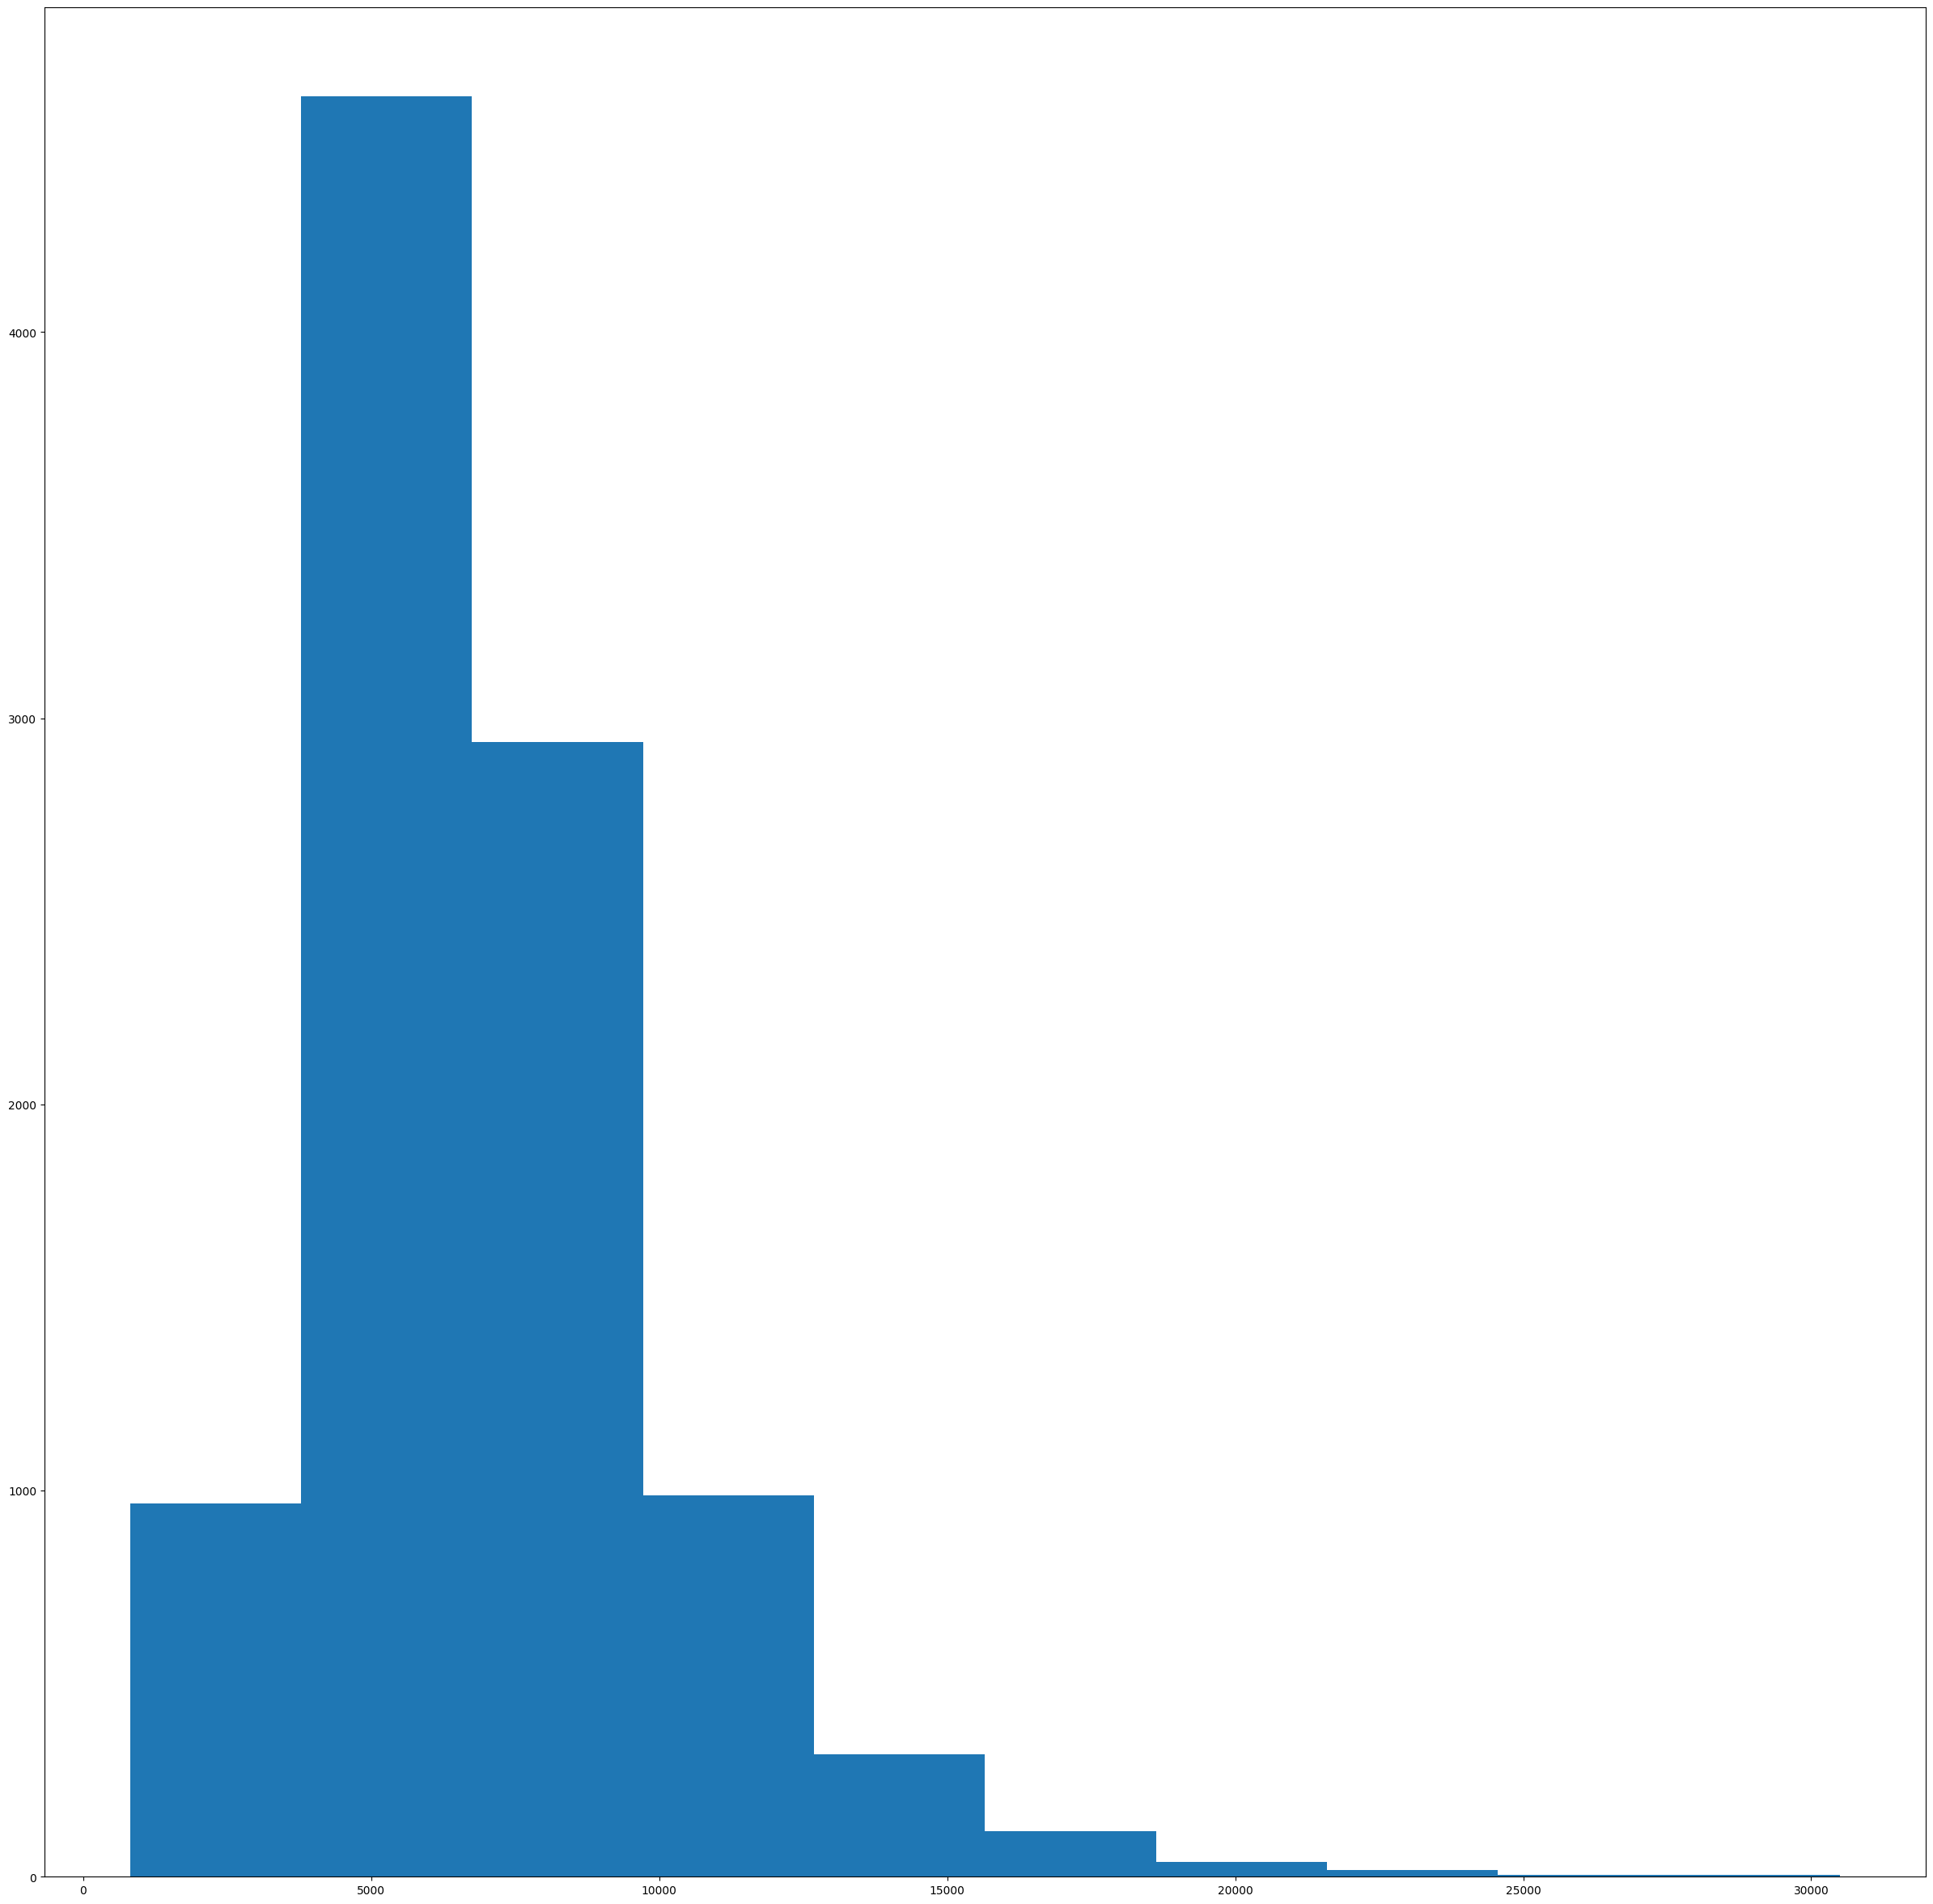

In [43]:
plt.hist(merged_df.Sales.sample(10000))

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

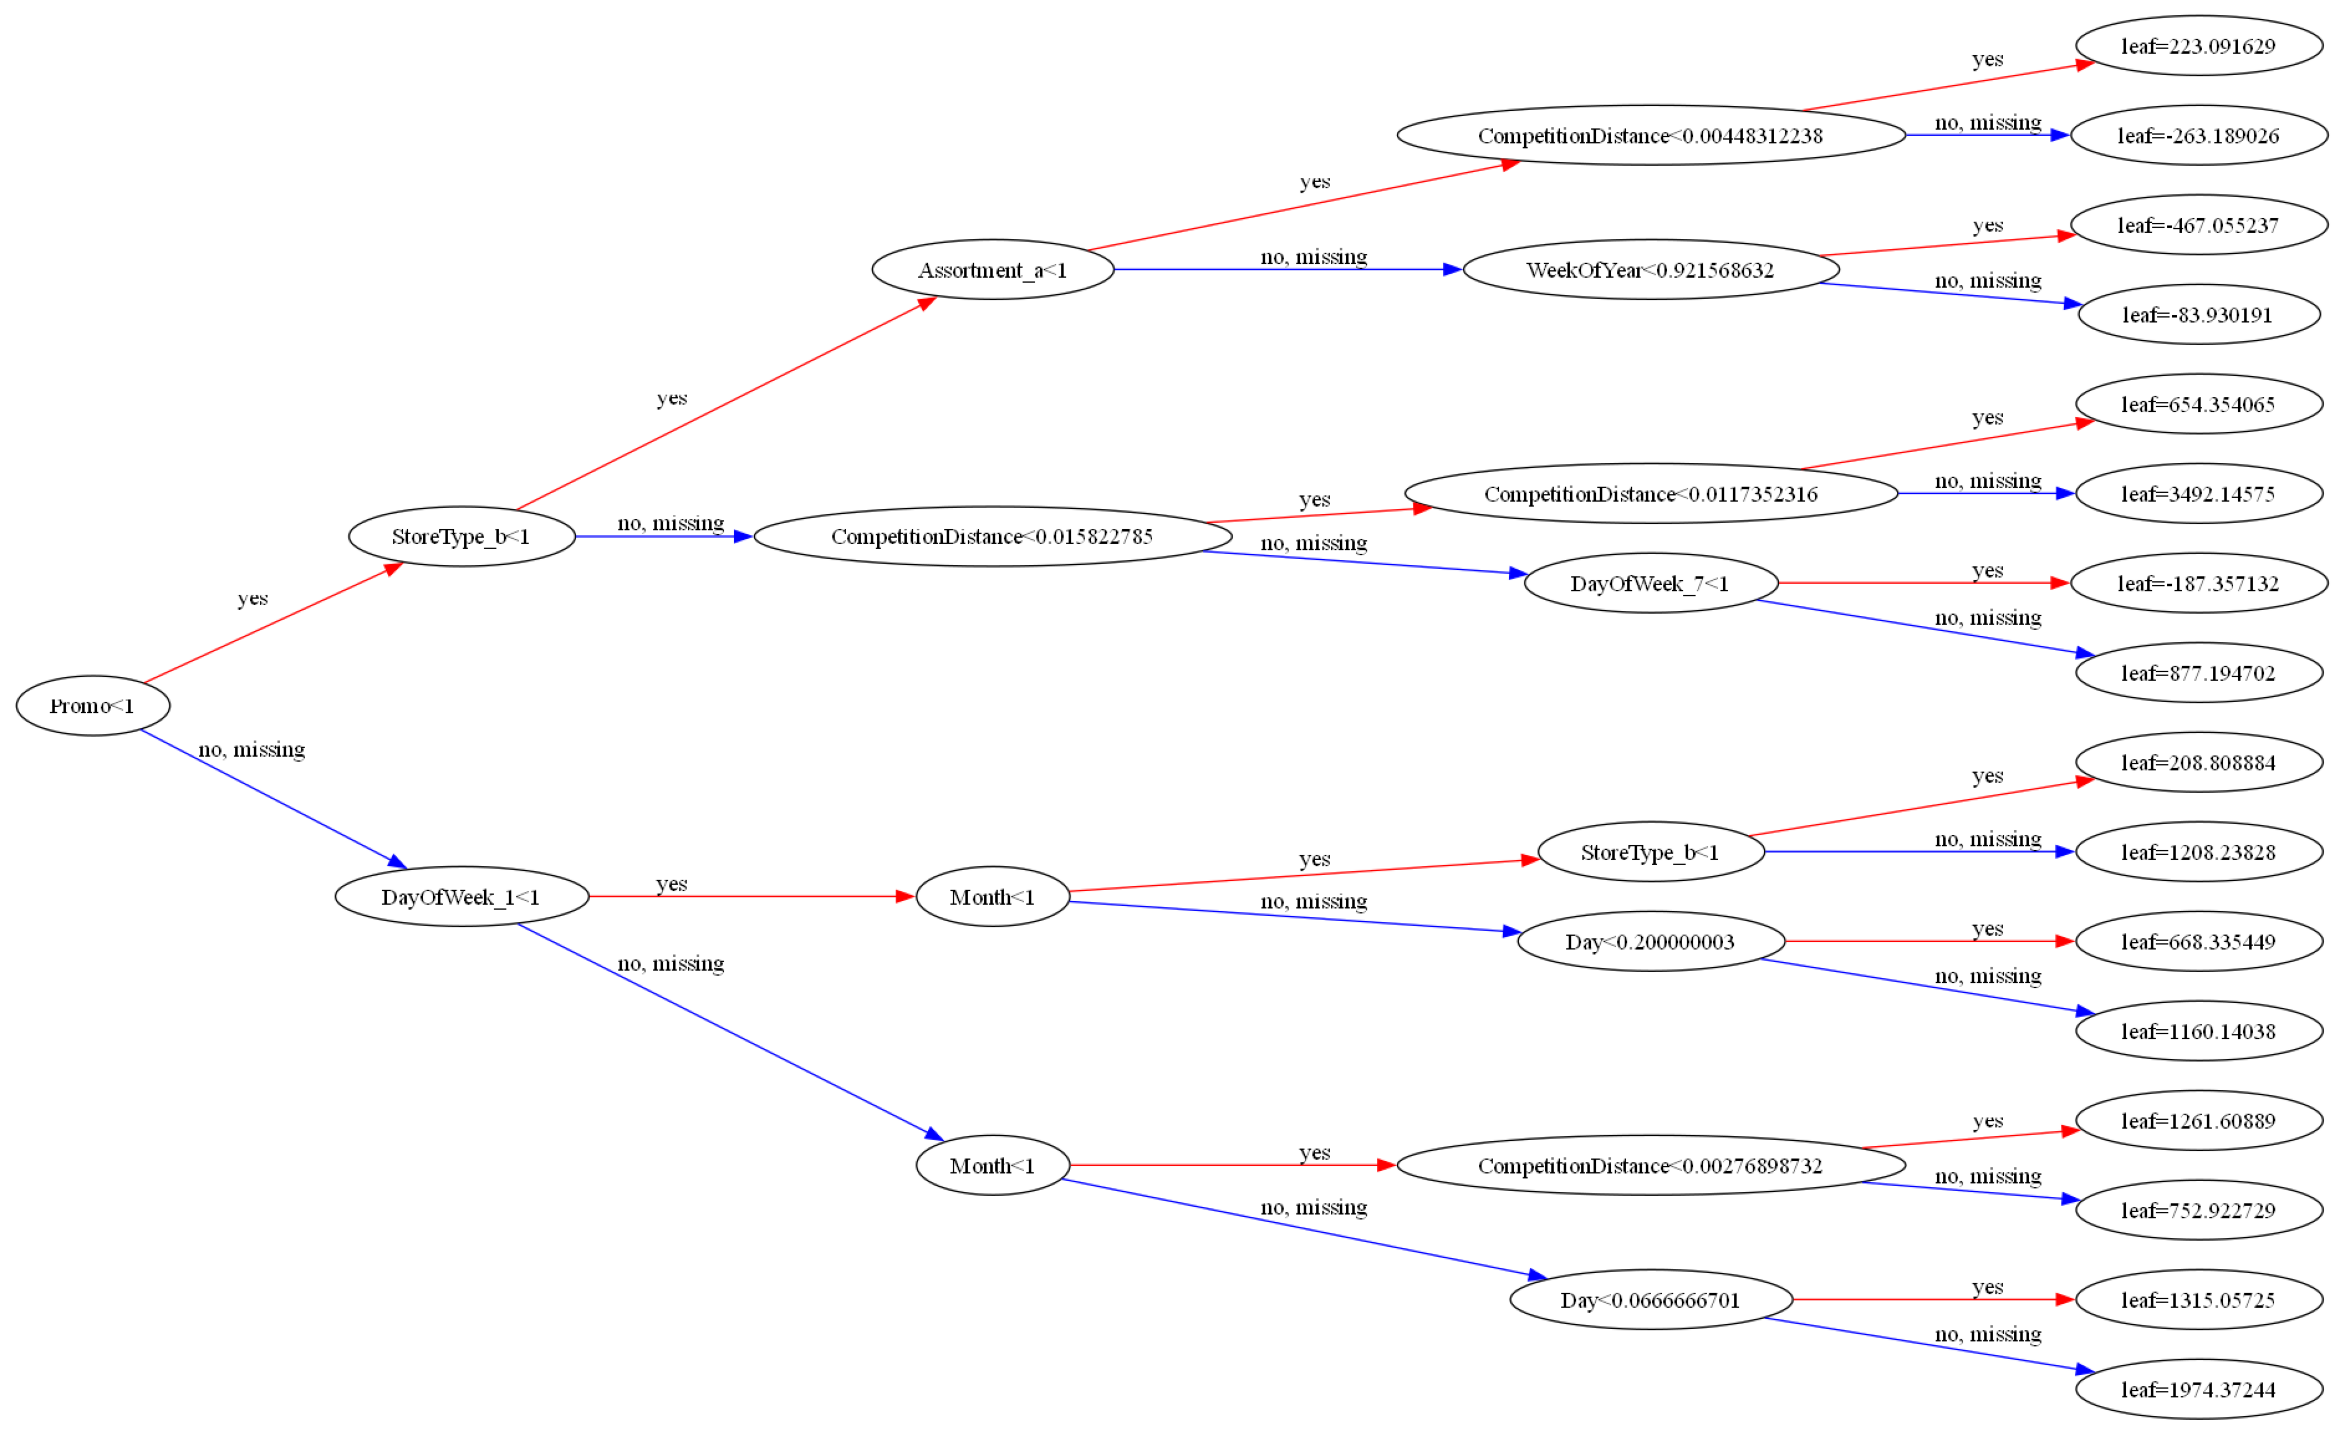

In [44]:
plot_tree(model, rankdir='LR');

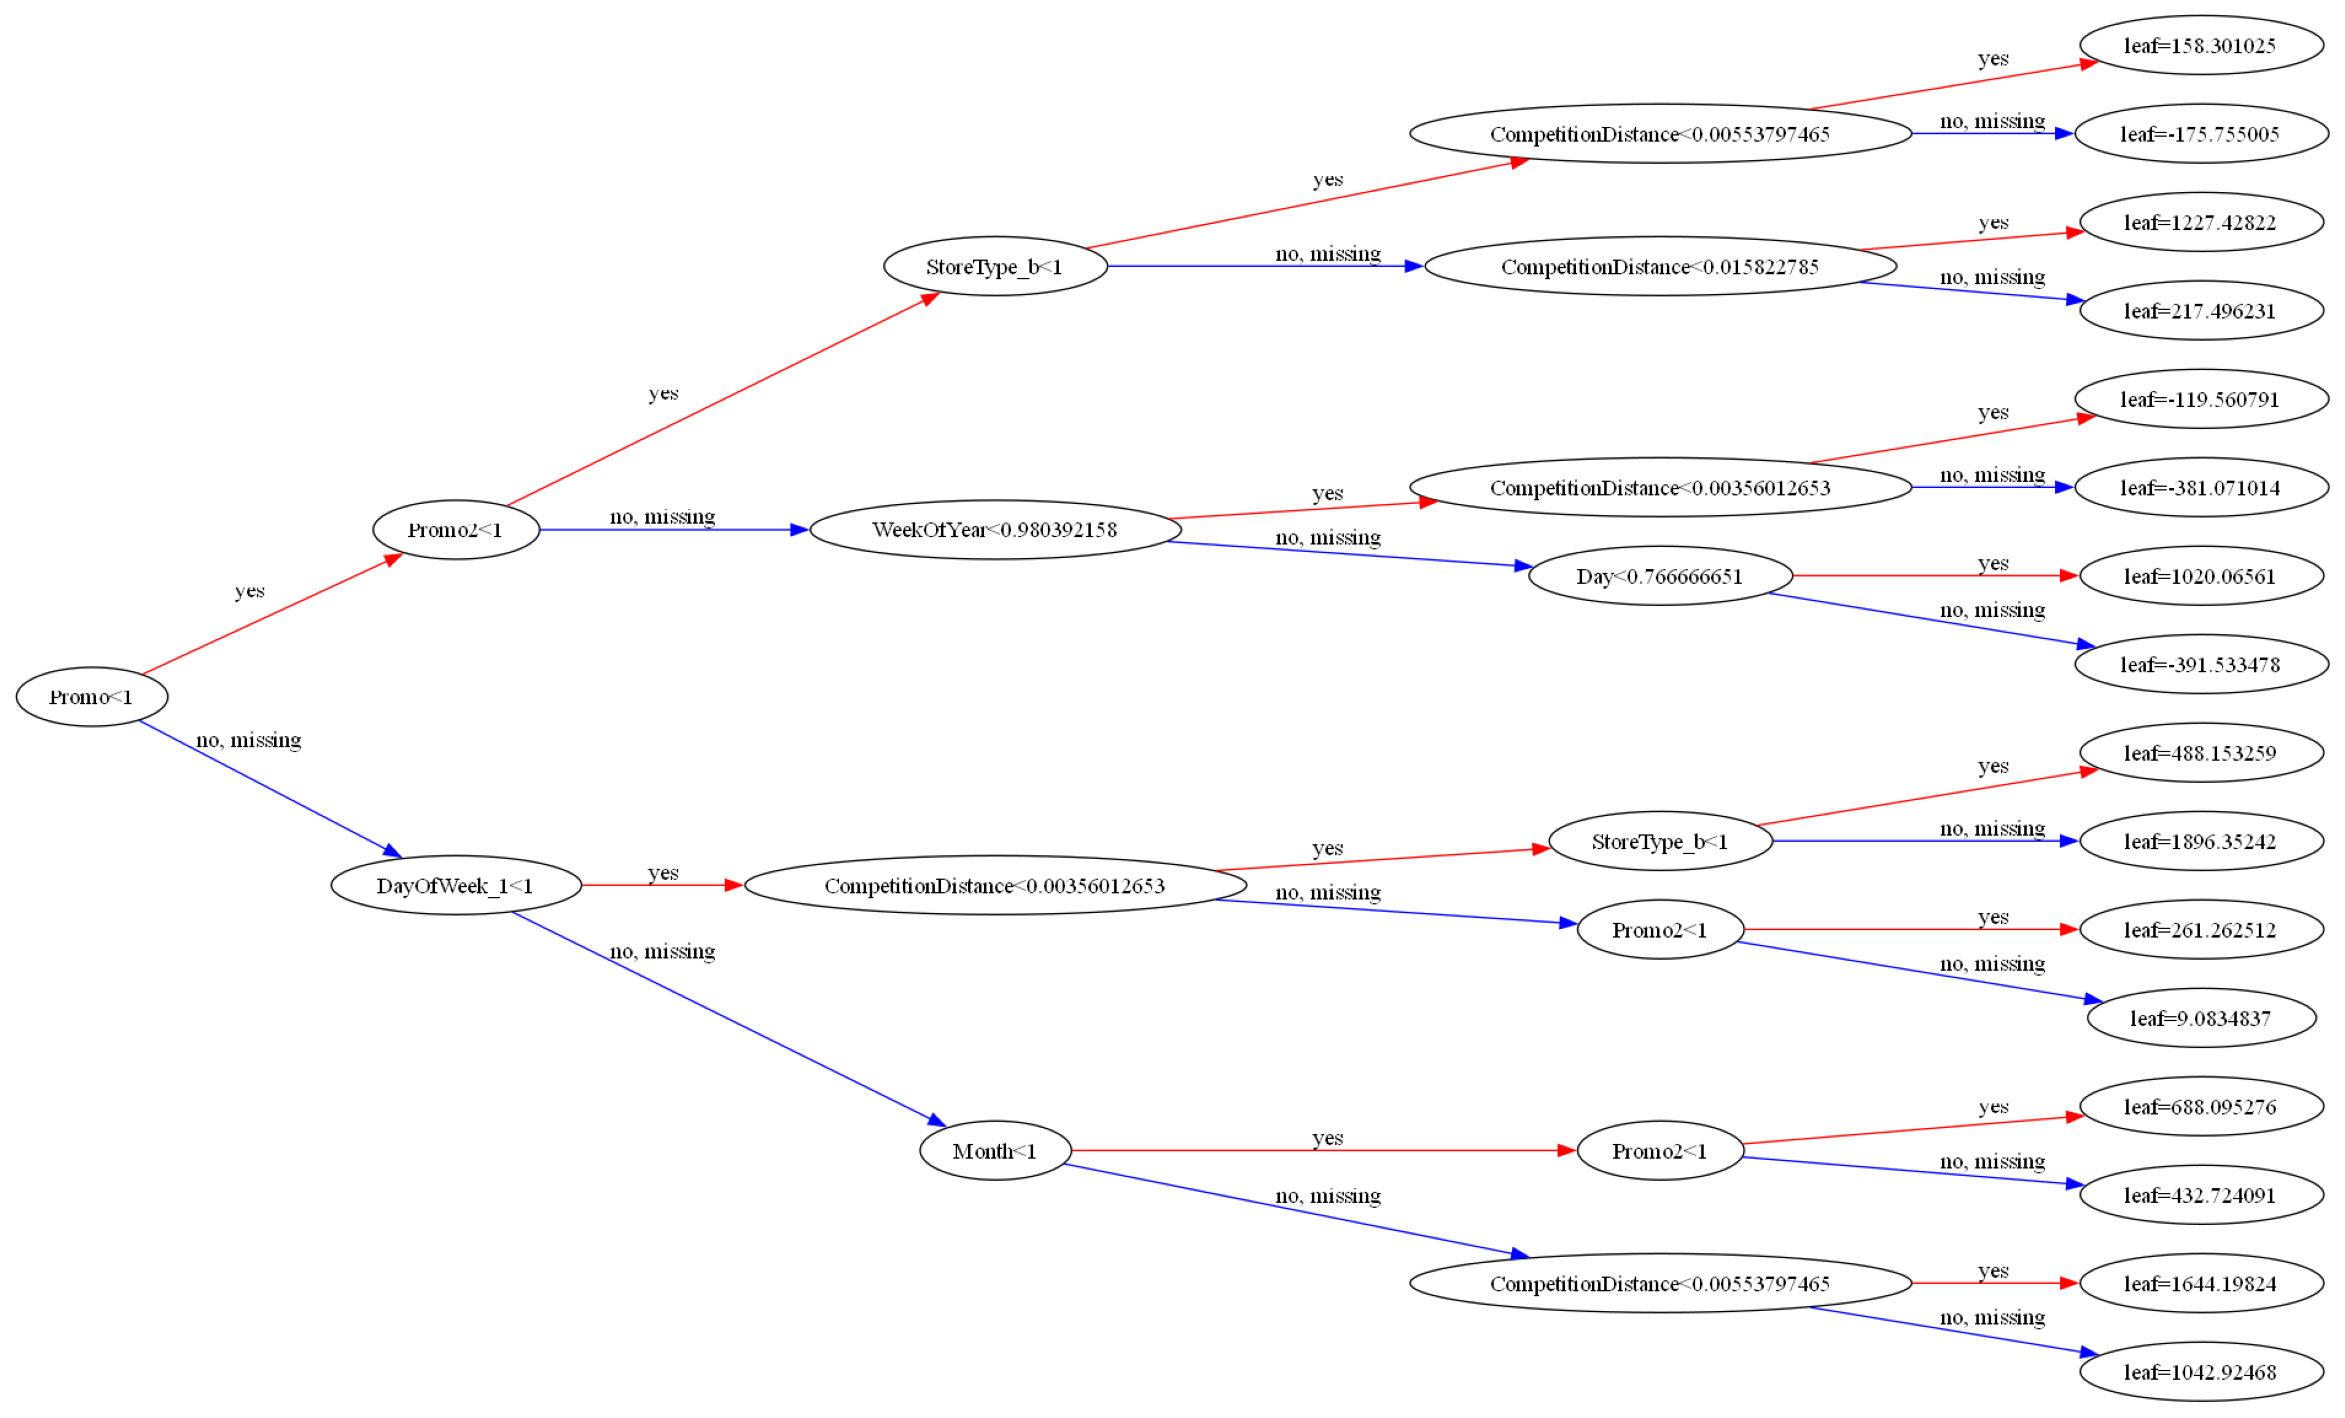

In [45]:
plot_tree(model, rankdir='LR', num_trees=1);

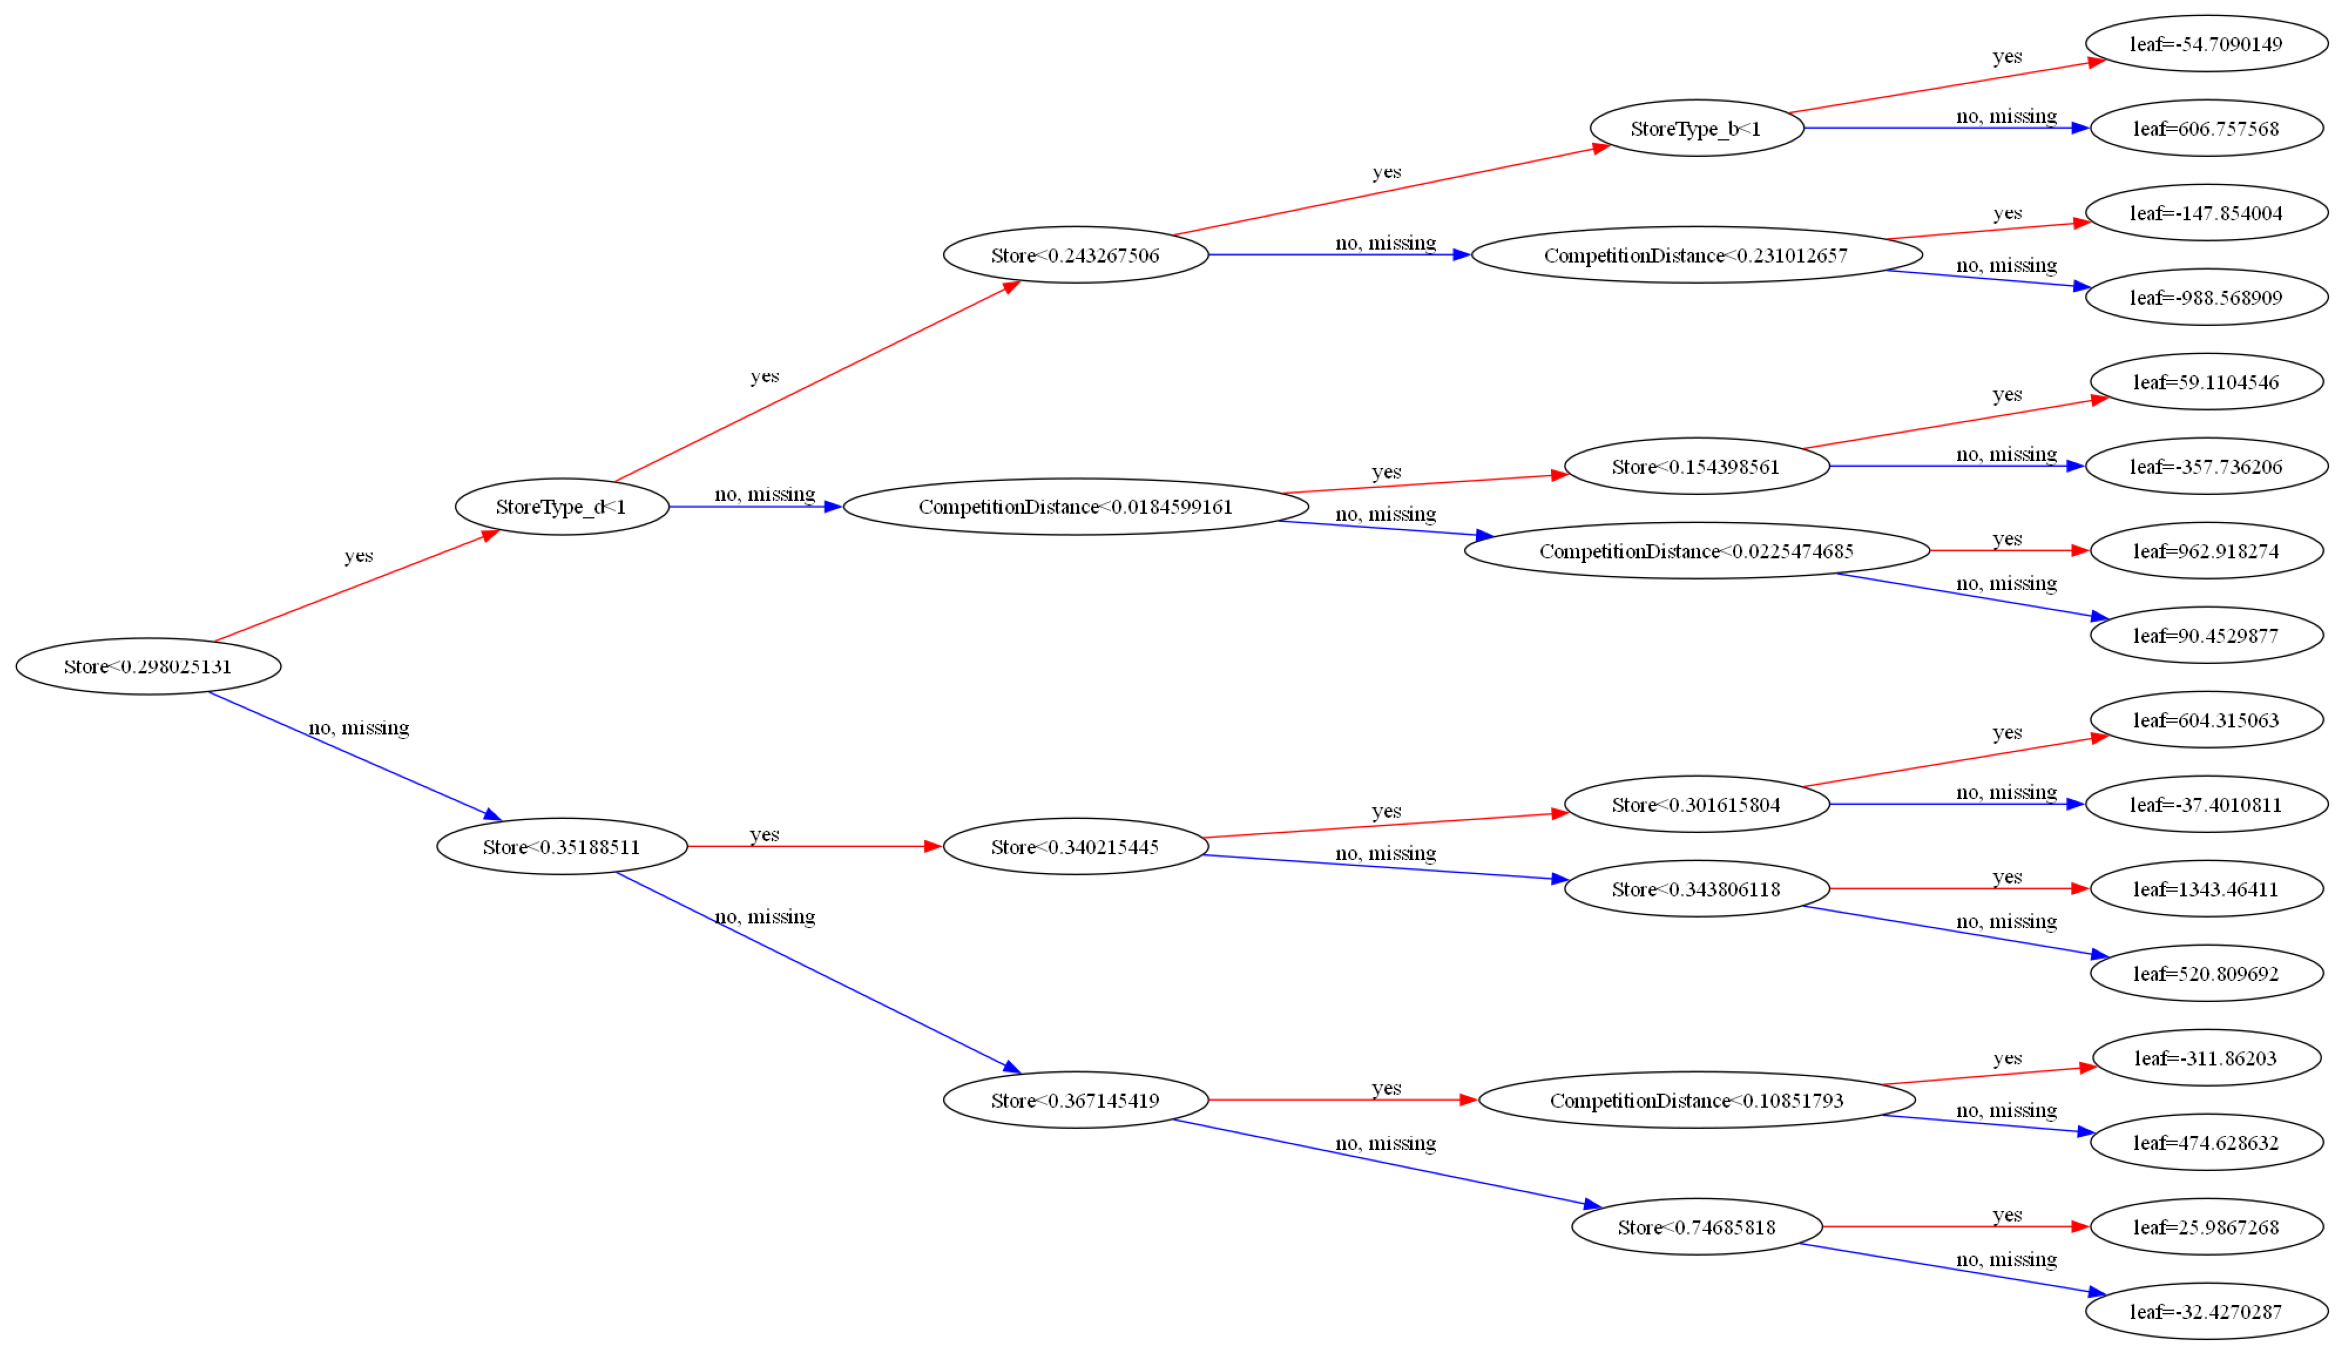

In [46]:
plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [47]:
trees = model.get_booster().get_dump()
len(trees)

20

In [48]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00276898732] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752.9

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [49]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
1,Promo,0.334846
12,DayOfWeek_1,0.076257
24,StoreType_b,0.069301
5,Promo2,0.052821
26,StoreType_d,0.051002
9,Month,0.036114
27,Assortment_a,0.034672
11,WeekOfYear,0.034646
29,Assortment_c,0.034157
3,CompetitionDistance,0.030939


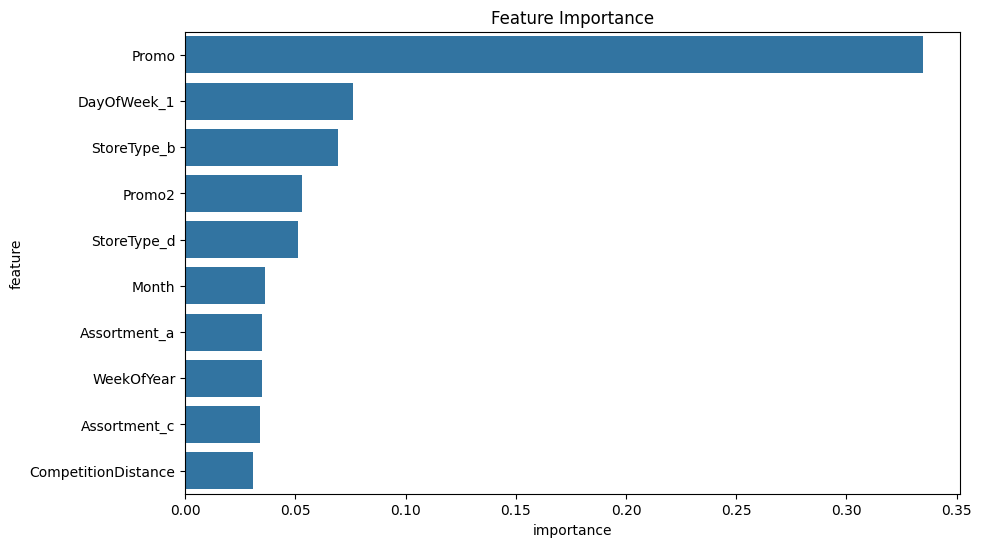

In [50]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):


Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [51]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [54]:
kfold = KFold(n_splits=5)

In [55]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2394.787841796875, Validation RMSE: 2462.850341796875
Train RMSE: 2401.158203125, Validation RMSE: 2449.841796875
Train RMSE: 2411.892822265625, Validation RMSE: 2391.591064453125
Train RMSE: 2344.831298828125, Validation RMSE: 2440.04443359375
Train RMSE: 2391.154541015625, Validation RMSE: 2460.874267578125


Let's also define a function to average predictions from the 5 different models.

In [58]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)
preds = predict_avg(models, X)
preds

array([8031.8696, 7536.164 , 8671.131 , ..., 7181.968 , 7955.146 ,
       9629.75  ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

Here's a helper function to test hyperparameters with K-fold cross validation.

In [59]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [61]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [62]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [63]:
test_params(n_estimators=10)

Train RMSE: 2364.80615234375, Validation RMSE: 2373.76513671875


In [64]:
test_params(n_estimators=30)

Train RMSE: 1843.2938232421875, Validation RMSE: 1848.6395263671875


In [65]:
test_params(n_estimators=100)

Train RMSE: 1149.3829345703125, Validation RMSE: 1166.8922119140625


In [67]:
test_params(n_estimators=240)

Train RMSE: 897.7741088867188, Validation RMSE: 923.7672729492188


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [68]:
test_params(max_depth=2)

Train RMSE: 2382.134765625, Validation RMSE: 2387.862060546875


In [69]:
test_params(max_depth=5)

Train RMSE: 1391.1810302734375, Validation RMSE: 1404.304931640625


In [70]:
test_params(max_depth=10)

Train RMSE: 662.8197021484375, Validation RMSE: 770.1036987304688


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [71]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 2789.010009765625, Validation RMSE: 2800.089111328125


In [72]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 2174.2509765625, Validation RMSE: 2178.580078125


In [73]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 1519.111572265625, Validation RMSE: 1529.470458984375


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [74]:
test_params(booster='gblinear')

Train RMSE: 2725.33642578125, Validation RMSE: 2733.49462890625


Clearly, a linear model is not well suited for this dataset.

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [78]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000,
                     learning_rate=0.2, max_depth=10, subsample=0.9,
                     colsample_bytree=0.7)

%time
model.fit(X, targets)

CPU times: total: 0 ns
Wall time: 0 ns


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Now that the model is trained, we can make predictions on the test set.

In [ ]:
test_preds = model.predict(X_test)
submission_df['Sales']  = test_preds

np.int64(11)

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [ ]:

test_df.Open.isna().sum()

In [82]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)
submission_df

,Id,Sales
0,1,3976.954346
1,2,8010.552246
2,3,8700.921875
3,4,7396.159668
4,5,7195.354492
...,...,...
41083,41084,2432.904541
41084,41085,6463.385254
41085,41086,5796.325684
41086,41087,21716.410156


We can now save the predictions as a CSV file.

In [90]:
submission_df.to_csv('submission.csv', index=None)
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

c:\Users\HARSH\2025\AGI\MLwithScikit-Learn\submission.csv

We can now make a submission on this page and check our score: https://www.kaggle.com/c/rossmann-store-sales/submit

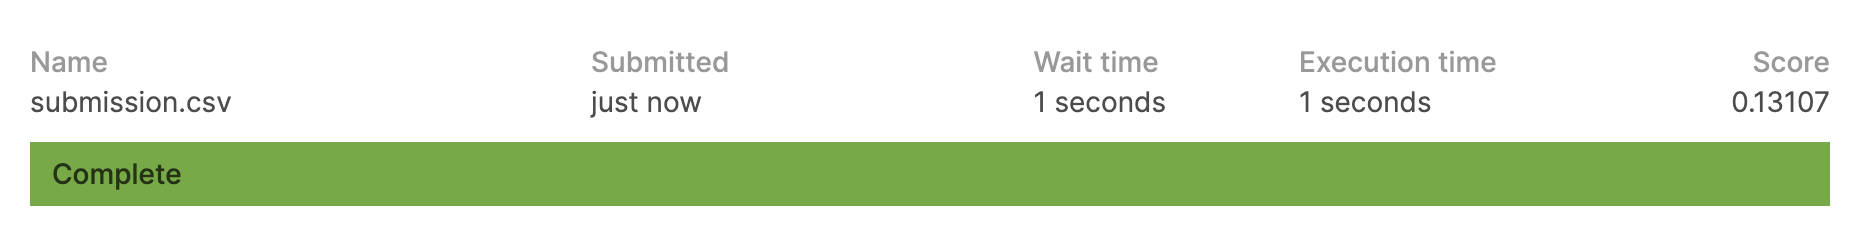

## Summary and References

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more: 

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1